In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#IMPORTS
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from src.data.make_dataset import *
from src.data.modal_data import *

In [9]:
# GET THE DATA
package_folder = os.path.dirname(os.path.dirname(os.getcwd()))
data_folder = os.path.join(package_folder, 'data')
print(data_folder)

location = 'nw2'
turbine = 'c02'

c:\Users\Max\Documents\OWI_LAB\Code\DCE_EOVnorm\dce_eov_normalisation\data


In [10]:
turbine_data = get_turbine_data(data_folder, location, turbine)
mpe_ss_data = get_mpe_data(turbine_data, 'SS', location, turbine)

c:\Users\Max\Documents\OWI_LAB\Code\DCE_EOVnorm\dce_eov_normalisation\data\raw\nw2\nw2c02.parquet


In [26]:
from src.data.harmonics import *
harmonics_data = harmonics(turbine_data.filter(regex='rpm'), [1,3,6, 9])

In [ ]:
from data_selector.lasso_data_selector import *
plt.figure(figsize=(30,6))

plt.scatter(mpe_ss2_data_plot_part1['timestamp'], mpe_ss2_data_plot_part1['mean_frequency'], s=3, alpha=0.6, color='grey')
for harmonic in harmonics_data.columns:
    plt.scatter(harmonics_data.loc[:middle].index, harmonics_data.loc[:middle][harmonic], s=2, alpha=0.1, color='k')
plt.ylim(0.9, 1.15)
legend = plt.legend(loc='lower left', labels=['SS2 modal frequencies', 'harmonics'])
for handles in legend.legendHandles:
    handles.set_sizes([50])
    handles.set_alpha(1.0)

plt.show()
plt.close()


In [40]:
from pytz import utc
mpe_ss2_data_plot = mpe_ss_data.copy().reset_index()
mpe_ss2_data_plot = mpe_ss2_data_plot[mpe_ss2_data_plot['mean_frequency'] < 1.2]
mpe_ss2_data_plot = mpe_ss2_data_plot[mpe_ss2_data_plot['mean_frequency'] > 0.9]

C:\Users\Max\AppData\Local\Temp\ipykernel_11376\4251557070.py:9: MatplotlibDeprecationWarning:

The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.



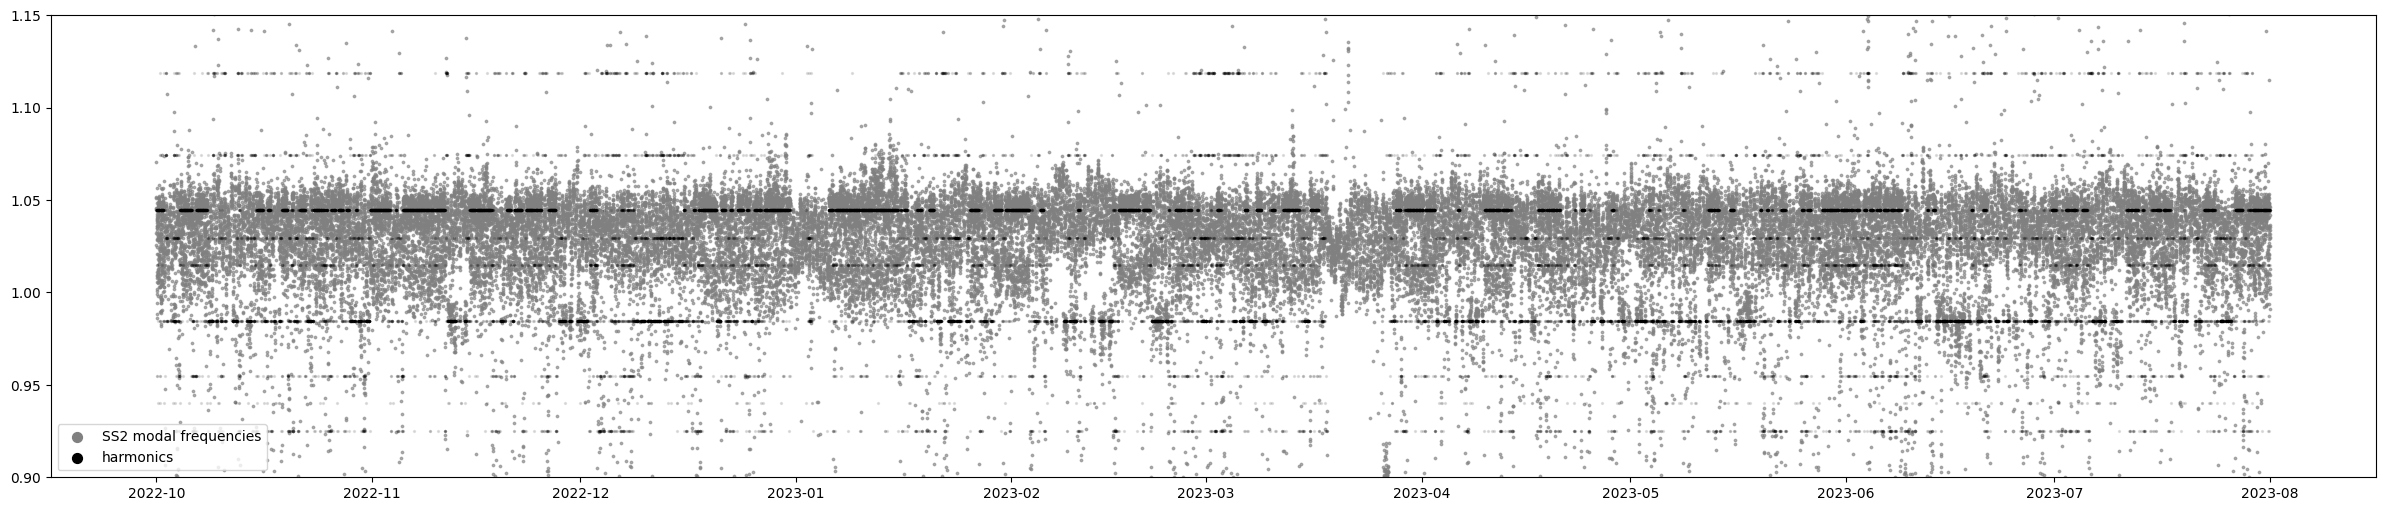

In [41]:
from data_selector.lasso_data_selector import *
plt.figure(figsize=(30,6))

plt.scatter(mpe_ss2_data_plot['timestamp'], mpe_ss2_data_plot['mean_frequency'], s=3, alpha=0.6, color='grey')
for harmonic in harmonics_data.columns:
    plt.scatter(harmonics_data.index, harmonics_data[harmonic], s=2, alpha=0.1, color='k')
plt.ylim(0.9, 1.15)
legend = plt.legend(loc='lower left', labels=['SS2 modal frequencies', 'harmonics'])
for handles in legend.legendHandles:
    handles.set_sizes([50])
    handles.set_alpha(1.0)

plt.show()
plt.close()


In [59]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output, State
import plotly.express as px
import pandas as pd

# Create a Dash app instance
app = dash.Dash(__name__)

# Load your dataset
# df = pd.read_csv("your_dataset.csv")

class DashLassoDataSelector:
    def __init__(self, df, fig_size=(800, 600), marker_size=10):
        self.df = df
        self.fig_size = fig_size
        self.marker_size = marker_size
        self.selected_data = pd.DataFrame()
        self.confirmed_data = pd.DataFrame()
        self.all_confirmed_data = {}
        self.confirmation_nr = 1
        self.app = app

        # Define the layout
        self.app.layout = html.Div([
            dcc.Graph(id='scatter-plot'),
            dcc.Dropdown(
                id='x-axis-dropdown',
                options=[{'label': col, 'value': col} for col in self.df.columns],
                value=self.df.columns[0]
            ),
            dcc.Dropdown(
                id='y-axis-dropdown',
                options=[{'label': col, 'value': col} for col in self.df.columns],
                value=self.df.columns[1]
            ),
            html.Button('Confirm Selection', id='confirm-button'),
            html.Div(id='confirmed-data-output')
        ])

        # Define callbacks
        self.app.callback(
            Output('scatter-plot', 'figure'),
            [Input('x-axis-dropdown', 'value'),
             Input('y-axis-dropdown', 'value')]
        )(self.update_scatter_plot)

        self.app.callback(
            Output('confirmed-data-output', 'children'),
            [Input('confirm-button', 'n_clicks')],
            [State('scatter-plot', 'selectedData')]
        )(self.confirm_selection)

    def run(self):
        self.app.run_server(debug=True)

    def update_scatter_plot(self, x_axis, y_axis):
        fig = px.scatter(self.df, x=x_axis, y=y_axis,
                         width=self.fig_size[0], 
                         height=self.fig_size[1])
        fig.update_traces(marker=dict(size=self.marker_size))
        return fig

    def confirm_selection(self, n_clicks, selected_data):
        if n_clicks is None:
            return "Select data points and click 'Confirm Selection'."

        if selected_data and 'points' in selected_data:
            indices = [point['pointIndex'] for point in selected_data['points']]
            self.selected_data = self.df.iloc[indices]
            self.confirmed_data = self.selected_data.copy()
            self.all_confirmed_data[self.confirmation_nr] = self.confirmed_data
            self.confirmation_nr += 1
            return f"Selection {self.confirmation_nr - 1} confirmed."

        return "No data selected. Select data points first."

if __name__ == '__main__':
    dash_app = DashLassoDataSelector(df, fig_size=(1600, 600), marker_size=5)
    dash_app.run()


In [65]:
dash_app.all_confirmed_data
selected_data = pd.concat([dash_app.all_confirmed_data[i] for i in dash_app.all_confirmed_data.keys()]).set_index('timestamp')

C:\Users\Max\AppData\Local\Temp\ipykernel_11376\2446333911.py:11: MatplotlibDeprecationWarning:

The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.



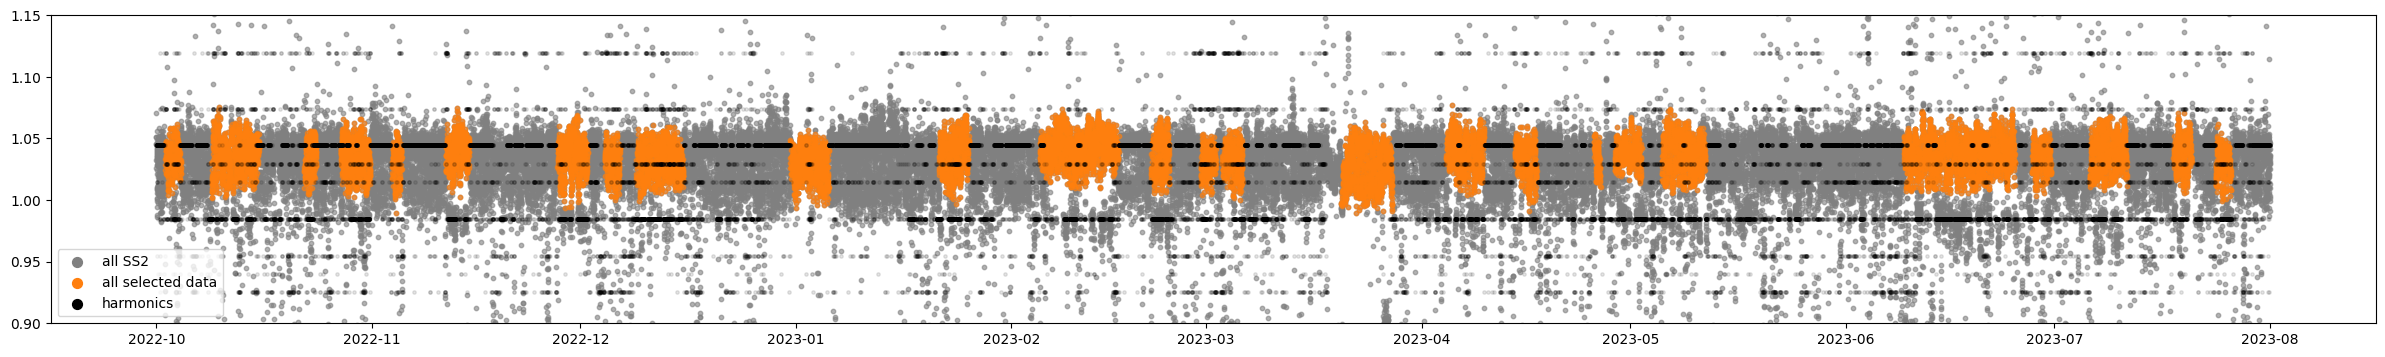

In [66]:
plt.figure(figsize=(30,4))

plt.scatter(mpe_ss_data.index, mpe_ss_data['mean_frequency'], s=10, alpha=0.6, color='grey')
#plt.scatter(mpe_ss_data_lowrpm.index, mpe_ss_data_lowrpm['mean_frequency'], s=10, alpha=0.6, color='tab:green')
plt.scatter(selected_data.index, selected_data['mean_frequency'], s=10, alpha=0.6, color='tab:orange')

for harmonic in harmonics_data.columns:
    plt.scatter(harmonics_data.index, harmonics_data[harmonic], s=6, alpha=0.1, color='k')
plt.ylim(0.9, 1.15)
legend = plt.legend(loc='lower left', labels=['all SS2', 'all selected data', 'harmonics'])
for handles in legend.legendHandles:
    handles.set_sizes([50])
    handles.set_alpha(1.0)

plt.show()
plt.close()

In [67]:
selected_data.to_csv(os.path.join(data_folder, 'processed','nw2', turbine+'_ss2_selected_data.csv'))